In [1]:
import os
import io
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 

C:\Users\Suleman\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv("listings.csv.gz") 
data.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2060,https://www.airbnb.com/rooms/2060,20200313233810,2020-03-14,Modern NYC,NaN,"Lovely, spacious, sunny 1 BR apartment in 6th ...","Lovely, spacious, sunny 1 BR apartment in 6th ...",none,NaN,...,f,f,flexible,f,f,1,0,1,0,0.01
1,2595,https://www.airbnb.com/rooms/2595,20200313233810,2020-03-14,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,2,2,0,0,0.38
2,3831,https://www.airbnb.com/rooms/3831,20200313233810,2020-03-14,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.71
3,5099,https://www.airbnb.com/rooms/5099,20200313233810,2020-03-14,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.59
4,5114,https://www.airbnb.com/rooms/5114,20200313233810,2020-03-14,Super Room in Great area.,NaN,"First, the area is PERFECT if you want to visi...","First, the area is PERFECT if you want to visi...",none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,1,2,0,0.56


In [3]:
len(data)

50796

In [4]:
#to get a count of missing values for each column, and what percent of each column is null 
data.isnull().sum()

total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum())/data.isnull().count().sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(25)

,Total,Percent
thumbnail_url,50796,1.000000
xl_picture_url,50796,1.000000
medium_url,50796,1.000000
jurisdiction_names,50781,0.999705
license,50759,0.999272
square_feet,50407,0.992342
monthly_price,46119,0.907926
weekly_price,45411,0.893988
notes,30273,0.595972
access,23984,0.472163


In [5]:
#remove columns with 50% or more null values 
   
data.drop(['thumbnail_url','xl_picture_url','medium_url','jurisdiction_names','license','square_feet','monthly_price','weekly_price','notes'], axis=1, inplace=True)


In [6]:
#fill certain attributes with 0 if n/a 
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)
data['bathrooms'] = data['bathrooms'].fillna(0)
data['bedrooms'] = data['bedrooms'].fillna(0)
data['security_deposit'] = data['security_deposit'].fillna(0)
data['space'] = data['space'].fillna(0)

In [7]:
#data exploration: see which hosts have the most listings
host_listings=data.host_id.value_counts().head(10)
host_listings

107434423    302
219517861    297
137358866    136
30283594     116
16098958     112
61391963     109
48005494     103
51501835      92
12243051      89
22541573      88
Name: host_id, dtype: int64

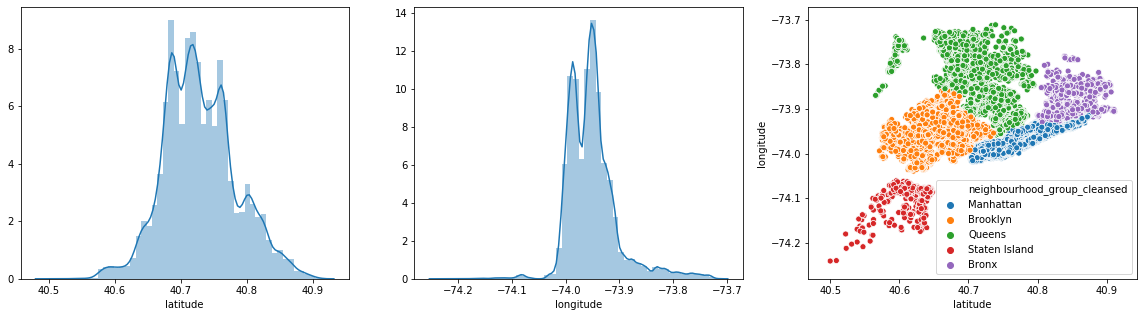

In [8]:
#visualization for latitude/longitude concentration areas
fig, axes = plt.subplots(1,3, figsize=(20,5))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude'], hue=data['neighbourhood_group_cleansed'])

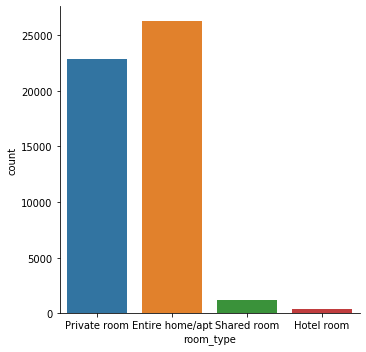

In [9]:
#visualization for type of room
sns.catplot(x='room_type', kind='count' ,data=data)
fig = plt.gcf()
fig.set_size_inches(5, 5)

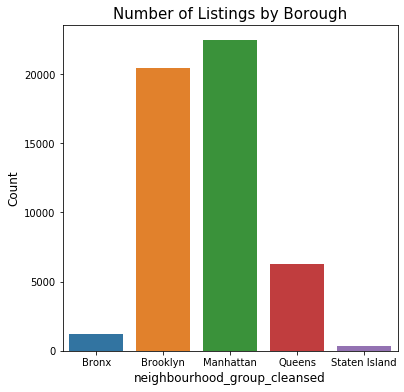

In [10]:
#Get a count by borough
borough_count = data.groupby('neighbourhood_group_cleansed').agg('count').reset_index()

#listings by borough
fig, ax1 = plt.subplots(1,1, figsize=(6,6)
                       )
sns.barplot(x='neighbourhood_group_cleansed', y='id', data=borough_count, ax=ax1)

ax1.set_title('Number of Listings by Borough', fontsize=15)
ax1.set_xlabel('neighbourhood_group_cleansed', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.tick_params(axis='both', labelsize=10)

In [11]:
#function to replace
def convert_bool(row):
    row = row.replace('f', '0')
    row = row.replace('t', '1')
    return row


#function to replace
def convert_string_to_int(row):
    row = row.replace('within an hour', '1')
    row = row.replace('within a few hours', '2')
    row = row.replace('within a day', '3')
    row = row.replace('a few days or more', '4')
    return row

In [12]:
# Extract the names of columns that are Numeric
numeric_data=data._get_numeric_data().columns

# Extract the names of columns that are Categorical
categorical_data=set(data.columns)-set(numeric_data) 

In [13]:
print (categorical_data)

{'require_guest_profile_picture', 'neighborhood_overview', 'extra_people', 'neighbourhood_cleansed', 'space', 'is_business_travel_ready', 'security_deposit', 'host_about', 'picture_url', 'host_acceptance_rate', 'price', 'neighbourhood', 'city', 'require_guest_phone_verification', 'host_is_superhost', 'cleaning_fee', 'host_neighbourhood', 'name', 'host_has_profile_pic', 'is_location_exact', 'transit', 'host_identity_verified', 'summary', 'requires_license', 'host_response_rate', 'house_rules', 'first_review', 'street', 'host_picture_url', 'instant_bookable', 'calendar_updated', 'bed_type', 'host_location', 'last_scraped', 'last_review', 'country_code', 'cancellation_policy', 'host_response_time', 'state', 'country', 'zipcode', 'experiences_offered', 'host_url', 'access', 'amenities', 'interaction', 'calendar_last_scraped', 'listing_url', 'host_verifications', 'has_availability', 'property_type', 'smart_location', 'host_since', 'host_thumbnail_url', 'room_type', 'description', 'market', 

In [14]:
print (numeric_data)

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object')


In [15]:
def fix_currency(row):
    row = row.replace(',', '')
    row = row.replace('$', '')
    return row

In [16]:
#fill with 0
Fill_with_zero = ['price', 'bathrooms', 'bedrooms', 'host_is_superhost', 'beds', 'review_scores_rating', 'review_scores_accuracy',
'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

for column in Fill_with_zero:
    data[column] = data[column].replace(np.nan, '0')

In [17]:
#Currency related
#fill with $0.00
Fill_with_zero = ['security_deposit', 'cleaning_fee']

for column in Fill_with_zero:
    data[column] = data[column].replace(np.nan, '$0.00')

In [18]:
#all dollars fields

def fix_currency(row):
    row = row.replace(',', '')
    row = row.replace('$', '')
    return row

In [19]:
# #update rows and convert to boolean, only non null values
Currency_columns = ['extra_people', 'cleaning_fee', 'security_deposit', 'price']


In [20]:
#for column in Currency_columns:
filt = data["security_deposit"]!=0

data["price"] = data["price"].apply(lambda col: fix_currency(col)).astype(float)
data["security_deposit"] = data["security_deposit"][filt].apply(lambda col: fix_currency(col))
data["cleaning_fee"] = data["cleaning_fee"].apply(lambda col: fix_currency(col))

In [21]:
#trying out the test/train split for linear regression -- we will put 40% of the dataset as a test

from sklearn.model_selection import train_test_split

X = data[["reviews_per_month", "bathrooms", "bedrooms"]]
y = data["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [22]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

In [23]:
regressor.fit(X_train, y_train)

LinearRegression()

In [24]:
regressor.predict(X_test)

array([148.07162751, 200.57248778, 148.29807684, ..., 133.67592047,
       148.07162751,  89.5860351 ])

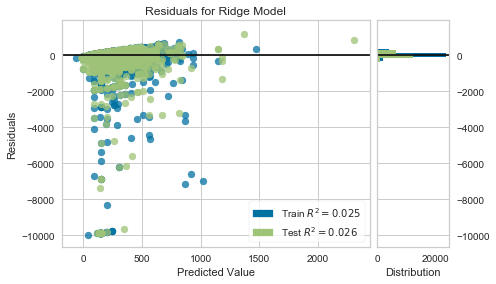

In [25]:
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, size=(500, 300))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

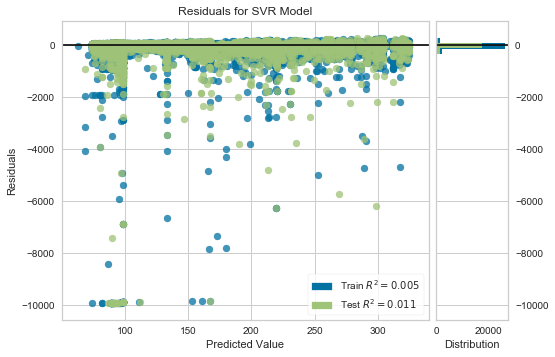

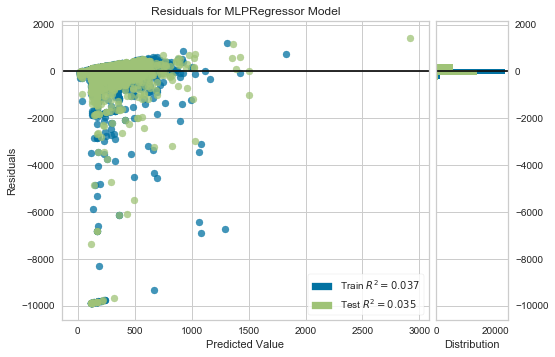

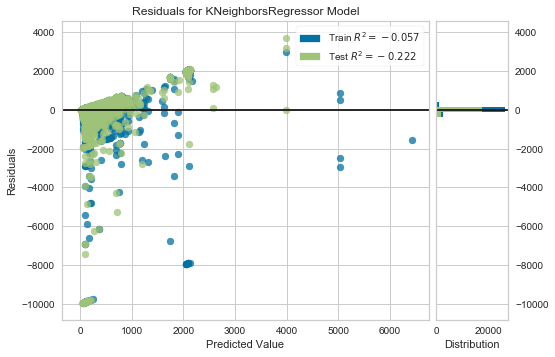

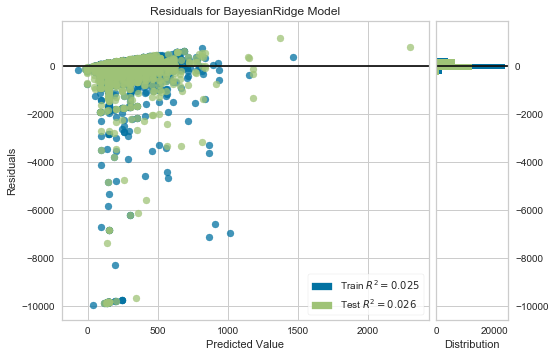

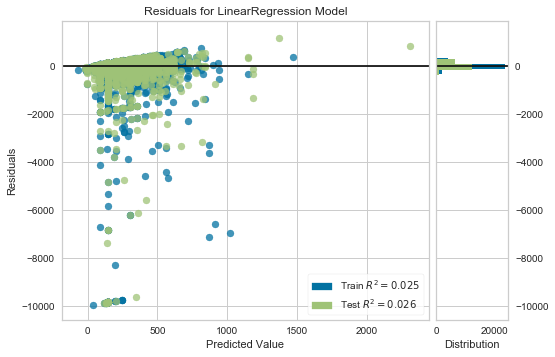

In [26]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression

regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [27]:
subway = pd.read_csv("NYC_Transit_Subway_Entrance_And_Exit_Data.csv") 

In [28]:
#to get a count of missing values for each column, and what percent of each column is null 
subway.isnull().sum()

total = subway.isnull().sum().sort_values(ascending=False)
percent = (subway.isnull().sum())/subway.isnull().count().sort_values(ascending=False)

missing_data_2 = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
#missing_data_2.head(25)

In [29]:
#remove columns with less than 50%
def less_than_50_percent(colname):
    total_row = subway.shape[0]
    isnull_count = subway[colname].isna().sum()
    if isnull_count/total_row > .4:
        return True

In [30]:
columns = list(subway)
remove_columns_0 = []
for column in columns:
    remove_column_y_n = less_than_50_percent(column)
    if remove_column_y_n:
        remove_columns_0.append(column)

print(remove_columns_0)

['Route2', 'Route3', 'Route4', 'Route5', 'Route6', 'Route7', 'Route8', 'Route9', 'Route10', 'Route11', 'Exit Only', 'Staff Hours', 'ADA Notes']


In [31]:
subway.shape

(1868, 32)

In [32]:
subway.isnull().sum()

Division                 0
Line                     0
Station Name             0
Station Latitude         0
Station Longitude        0
Route1                   0
Route2                 848
Route3                1374
Route4                1547
Route5                1630
Route6                1741
Route7                1788
Route8                1820
Route9                1840
Route10               1845
Route11               1845
Entrance Type            0
Entry                    0
Exit Only             1812
Vending                  0
Staffing                 0
Staff Hours           1828
ADA                      0
ADA Notes             1793
Free Crossover           0
North South Street      29
East West Street        35
Corner                  32
Entrance Latitude        0
Entrance Longitude       0
Station Location         0
Entrance Location        0
dtype: int64

In [33]:
column_with_nan = subway.columns[subway.isnull().any()]

for column in column_with_nan:
     print(column, subway[column].isnull().sum())

Route2 848
Route3 1374
Route4 1547
Route5 1630
Route6 1741
Route7 1788
Route8 1820
Route9 1840
Route10 1845
Route11 1845
Exit Only 1812
Staff Hours 1828
ADA Notes 1793
North South Street 29
East West Street 35
Corner 32


In [34]:
for column in column_with_nan:
    if subway[column].isnull().sum()*100.0 > 50:
        subway.drop(column,1, inplace=True)

In [35]:
subway.shape

(1868, 16)

In [36]:
subway.head(5)

,Division,Line,Station Name,Station Latitude,Station Longitude,Route1,Entrance Type,Entry,Vending,Staffing,ADA,Free Crossover,Entrance Latitude,Entrance Longitude,Station Location,Entrance Location
0,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,NONE,False,False,40.660489,-73.998220,"(40.660397, -73.998091)","(40.660489, -73.99822)"
1,BMT,4 Avenue,25th St,40.660397,-73.998091,R,Stair,YES,YES,FULL,False,False,40.660323,-73.997952,"(40.660397, -73.998091)","(40.660323, -73.997952)"
2,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,False,True,40.654676,-74.004306,"(40.655144, -74.003549)","(40.654676, -74.004306)"
3,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,False,True,40.654365,-74.004113,"(40.655144, -74.003549)","(40.654365, -74.004113)"
4,BMT,4 Avenue,36th St,40.655144,-74.003549,N,Stair,YES,YES,FULL,False,True,40.654490,-74.004499,"(40.655144, -74.003549)","(40.65449, -74.004499)"


In [46]:
Counts_of_Division = subway.groupby('Division').nunique()
print(Counts_of_Division)


          Division  Line  Station Name  Station Latitude  Station Longitude  \
Division                                                                      
BMT              1    12           125               140                140   
IND              1    11           143               150                150   
IRT              1    13           157               182                182   

          Route1  Entrance Type  Entry  Vending  Staffing  ADA  \
Division                                                         
BMT           12              7      2        2         3    2   
IND           10              6      2        2         3    2   
IRT           18              6      2        2         4    2   

          Free Crossover  Entrance Latitude  Entrance Longitude  \
Division                                                          
BMT                    2                438                 440   
IND                    2                716                 715   
IRT  